In [2]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

In [3]:
TRAIN_DIR = 'train'
TEST_DIR = 'test'
IMG_SIZE = 50
LR = 1e-3

MODEL_NAME = 'dogsVscat-{}-{}.model'.format(LR, '6conv-Basic-VIDEOS')

In [4]:
def label_img(img):
    word_label = img.split('.')[-3]
    if word_label == 'cat' : return [1,0]
    elif word_label == 'dog' : return [0,1]

In [5]:
def creat_train_data():
    train_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE,IMG_SIZE))
        train_data.append([np.array(img),np.array(label)])
    shuffle(train_data)
    np.save('train_data.npy', train_data)
    return train_data
        
        

In [6]:
def process_test_data():
    test_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE,IMG_SIZE))
        test_data.append([np.array(img),img_num])
        
        
    np.save("test_data.npy",test_data)
    return test_data

In [7]:
trained_data = creat_train_data()

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [00:29<00:00, 858.45it/s]
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [8]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression


import tensorflow
from tensorflow.python.framework import ops
ops.reset_default_graph()




convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir = 'log')

Instructions for updating:
non-resource variables are not supported in the long term
curses is not supported on this machine (please install/reinstall curses for an optimal experience)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('Model Loaded!')

INFO:tensorflow:Restoring parameters from C:\Users\chuza\Downloads\Deap_Learning\dogsVscat-0.001-6conv-Basic-VIDEOS.model
Model Loaded!


In [10]:
train = trained_data[:-500]
test = trained_data[-500:]

In [11]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]


test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]


In [12]:
model.fit({'input': X}, {'targets': Y}, n_epoch=10, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 13404  | total loss: 0.12686 | time: 60.888s
| Adam | epoch: 010 | loss: 0.12686 - acc: 0.9484 -- iter: 24448/24500
Training Step: 13405  | total loss: 0.11995 | time: 62.028s
| Adam | epoch: 010 | loss: 0.11995 - acc: 0.9520 | val_loss: 0.31783 - val_acc: 0.8820 -- iter: 24500/24500
--


In [13]:
model.save(MODEL_NAME)
t_data = process_test_data()

INFO:tensorflow:C:\Users\chuza\Downloads\Deap_Learning\dogsVscat-0.001-6conv-Basic-VIDEOS.model is not in all_model_checkpoint_paths. Manually adding it.


100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [01:43<00:00, 120.27it/s]
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


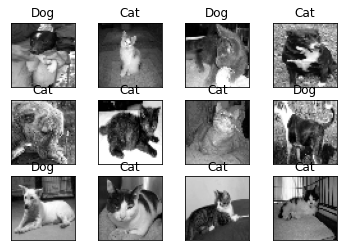

In [14]:
import matplotlib.pyplot as plt
import pickle
import numpy as np

tested_data = np.load('test_data.npy', allow_pickle=True)
fig = plt.figure()

for num,data in enumerate(tested_data[:12]):
    #cat : [1,0]
    #dog : [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label = 'Dog'
    else:str_label = 'Cat'
    y.imshow(orig, cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()


In [15]:
with open('submission_file.csv','w') as f:
    f.write('id,lable\n')

In [16]:
with open('submission_file.csv','a') as f:
    for data in tqdm(t_data):
        
        img_num = data[1]
        img_data = data[0]

        
        orig = img_data
        data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
        model_out = model.predict([data])[0]
        f.write('{}.{}'.format(img_num, model_out[1]))


100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [00:22<00:00, 563.48it/s]
